Final Project IDE20K 
============


In [1]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 4.1 MB/s 
     |████████████████████████████████| 418 kB 55.5 MB/s 
     |████████████████████████████████| 140 kB 74.0 MB/s 
     |████████████████████████████████| 596 kB 30.5 MB/s 
     |████████████████████████████████| 1.1 MB 43.5 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 271 kB 48.5 MB/s 
     |████████████████████████████████| 144 kB 25.5 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Preparation

## Imports

In [2]:
import os
print(os.getcwd())

from google.colab import drive
drive.mount('/content/drive')

/content
Mounted at /content/drive


In [3]:
os.listdir()
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'FinalProject/12/exercise_12'
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
os.chdir(GOOGLE_DRIVE_PATH)
print(os.listdir(GOOGLE_DRIVE_PATH))

['exercise_code', 'models', '.tmp', 'lightning_logs', 'images', 'weight3.pt', 'weight4.pt', 'weight5.pt', 'weight6.pt', 'weight7.pt', 'weight8.pt', 'weight9.pt', 'weight10.pt', 'weight11.pt', 'weight12.pt', 'weight13.pt', 'weight14.pt', 'weight15.pt', 'weight16.pt', 'weight17.pt', 'weight18.pt', 'weight19.pt', 'weight20.pt', 'prediction', 'weight21.pt', 'weight2.pt', 'demo.ipynb', 'training.ipynb']


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import pytorch_lightning as pl

from exercise_code.data.segmentation_dataset import SegmentationData, label_img_to_rgb
from exercise_code.util import visualizer, save_prediction
from exercise_code.networks.segmentation_nn import SegmentationNN

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Load Data



In [5]:
path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(path, 'datasets', 'segmentation')

train_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/training.txt', folder='training', val_type='.png')
val_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/validation.txt', folder='validation', val_type='.png')

In [6]:
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=False, num_workers=2)

# 2. Semantic Segmentation 

## Model Design



In [7]:
hparams = {
    "height":240, "width":240, "loss":torch.nn.CrossEntropyLoss(ignore_index=0, reduction='mean'),
    "lr":1e-2, "train_dataset":train_data, "batch_size":16
}

In [8]:
model = SegmentationNN(hparams = hparams)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

## Model Training

In [9]:
model = SegmentationNN(hparams=hparams)					
model.load_state_dict(torch.load('weight21.pt'))

<All keys matched successfully>

In [11]:
trainer = pl.Trainer(max_epochs=1, gpus=0, fast_dev_run=False, log_every_n_steps=1)

trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name       | Type       | Params
------------------------------------------
0 | features   | Sequential | 2.5 M 
1 | conv_to101 | Conv2d     | 26.0 K
2 | upsample   | Upsample   | 0     
------------------------------------------
26.0 K    Trainable params
2.5 M     Non-trainable params
2.5 M     Total params
9.983     Total estimated m

Training: 0it [00:00, ?it/s]

## Save the Weights for Submission



In [ ]:
torch.save(model.state_dict(), "weight22.pt")

# Model Evaluation

In [ ]:
def mIOU(label, pred, num_classes=101):
    iou_list = list()
    present_iou_list = list()

    pred = pred.view(-1)
    label = label.view(-1)
    for sem_class in range(1, num_classes):
        pred_inds = (pred == sem_class)
        target_inds = (label == sem_class)
        if target_inds.long().sum().item() == 0:
            iou_now = float('nan')
        else: 
            intersection_now = (pred_inds[target_inds]).long().sum().item()
            union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)
        iou_list.append(iou_now)
    return np.mean(present_iou_list)

def meanIOU(model, dataloader):
    model.eval()
    sample_size = len(val_data)

    preds = Variable(torch.zeros((sample_size, 1, 240, 240)))
    gts = Variable(torch.zeros((sample_size, 1, 240, 240)))

    dataiter = iter(dataloader)
    for i in range(sample_size):
        inputs, targets, _, _, _ = dataiter.next()
        inputs, targets = inputs.to(device), targets.to(device)

        gts[i] = targets.cpu()

        outputs = model.forward(inputs)
        _, pred = torch.max(outputs, 1)
        preds[i] = pred.cpu()

    return mIOU(preds, gts)

In [ ]:
meanIOU(model, val_loader)

0.03000276245622093

# Visualization

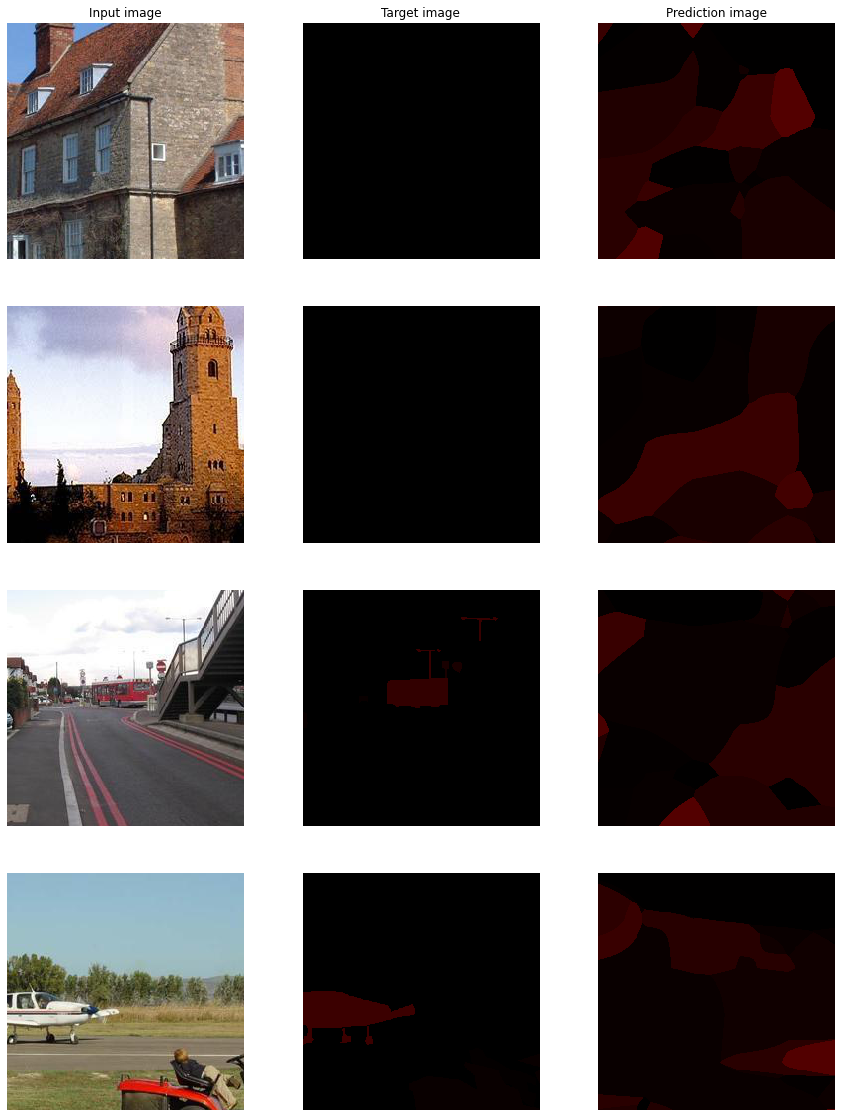

In [ ]:
visualizer(model, val_data)